In [1]:
from pyrl.agents.classic import DQNAgent
from pyrl.agents.survival import SurvivalDQNAgent
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

from tensorforce.agents import Agent
from tensorforce.environments import Environment
from pyrl.environments import CustomEnvironment
from tensorforce.execution import Runner

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from tensorforce.agents import Agent as TFAgent
from tensorforce.core.networks import AutoNetwork


In [2]:
map_size = (50, 5)
horizon = 5000
points = 6
repeat = 3
survival_threshold = 250
exploration_threshold = 500
gamma = 0.99 # discount factor
# initial_budgets = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
initial_budgets = np.linspace(100, horizon, points, dtype=int)

replay_capacity = 5000
batch_size = 256
exploration_rate = 0.5
update_frequency = 0.5
target_sync_frequency = 1000 # Interval between target network updates (default: every update).
start_updating = batch_size
optimizer = 'adamW'
# network = AutoNetwork(size=256, depth=10, final_depth=1)
policy = dict(
        type='parametrized_distributions',
        network = [
            dict(type='conv2d', size=32, window=3, stride=1, activation='relu'),
            dict(type='flatten'),
            dict(type='dense', size=64, activation='relu'),
            dict(type='dense', size=64, activation='relu')
        ],
        single_output=False
    )

In [3]:
env = Environment.create(
    environment=CustomEnvironment(render_mode="human", size=map_size),
    max_episode_timesteps=horizon,
    discount=gamma,
    exploitation_rate=(1-exploration_rate)
)

survival_dqn_time_mean = np.full(initial_budgets.shape, -1)
survival_dqn_exploration_rate = np.full(initial_budgets.shape, -1)
survival_dqn_alive_rate = np.full(initial_budgets.shape, -1)
survival_dqn_budget_evolutions = list()

survival_dqn_budget_evolutions_mean = np.full(initial_budgets.shape, None)
survival_dqn_budget_evolutions_max = np.full(initial_budgets.shape, None)
survival_dqn_budget_evolutions_min = np.full(initial_budgets.shape, None)


observation_space = env.states
action_space = env.actions()

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Survival DQN {b} | Try {j + 1}")
        agent = SurvivalDQNAgent(environment=env,
                                 memory=replay_capacity,
                                 batch_size=batch_size,
                                 initial_budget=b,
                                 policy=policy,
                                #  optimizer=optimizer,
                                 survival_threshold=survival_threshold,
                                 exploration_threshold=exploration_threshold,
                                 exploration=exploration_rate,
                                 discount=gamma,
                                 max_episode_timesteps=horizon,
                                 actions_exploration=exploration_rate,
                                 start_updating=start_updating,
                                 )
        states = env.reset()
        
        agent.reset(states)
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        budget_evolution = np.zeros((horizon,), dtype=int)
        
        for t in count():
            actions = agent.act(states=states)
            states, terminated, reward= env.execute(actions=actions)
            # reward = (old_manhattan_distance - gamma*new_manhattan_distance)/(1-exploration_rate) + budget_reward
            done = terminated or t >= horizon or agent.b <= 0
            
            exploration_matrix[int(states), int(actions)] = exploration_matrix[int(states), int(actions)] + 1
            

            agent.observe(states, reward, terminated=terminated)

            # print(agent.agent.spec["exploration"])
            
            env.render()
            
            budget_evolution[t-1] = agent.b

            if done:
                print("t = ", t)
                if survival_dqn_time_mean[i] == -1:
                    survival_dqn_time_mean[i] = t
                else:
                    survival_dqn_time_mean[i] = survival_dqn_time_mean[i] + (1/(j+1)) * (t - survival_dqn_time_mean[i])
                break
        
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if survival_dqn_exploration_rate[i] == -1:
            survival_dqn_exploration_rate[i] = exploration_rate
        else:
            survival_dqn_exploration_rate[i] = survival_dqn_exploration_rate[i] + (1 / (j+1)) * (exploration_rate - survival_dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        survival_dqn_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if survival_dqn_budget_evolutions_mean[i] is None:
            survival_dqn_budget_evolutions_mean[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_mean[i] = survival_dqn_budget_evolutions_mean[i] + (1 / (j+1)) * (budget_evolution - survival_dqn_budget_evolutions_mean[i])

        # budget evolution max
        if survival_dqn_budget_evolutions_max[i] is None:
            survival_dqn_budget_evolutions_max[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_max[i] = np.maximum(survival_dqn_budget_evolutions_max[i], budget_evolution)

        # budget evolution min
        if survival_dqn_budget_evolutions_min[i] is None:
            survival_dqn_budget_evolutions_min[i] = budget_evolution
        else:
            survival_dqn_budget_evolutions_min[i] = np.minimum(survival_dqn_budget_evolutions_min[i], budget_evolution)
        
        
        print(f"Time mean : {survival_dqn_time_mean[i]}")
        print(f"Alive rate : {survival_dqn_alive_rate[i]}%")
        print(f"Exploration rate: {survival_dqn_exploration_rate[i]}%")

====> Survival DQN 100 | Try 1


c:\Users\ayman\miniconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("policy_optimizer/PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("policy_optimizer/PartitionedCall:1", shape=(None, 64), dtype=float32), dense_shape=Tensor("policy_optimizer/PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Survival DQN 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Survival DQN 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 5%
====> Survival DQN 1080 | Try 1
t =  1146
Time mean : 1146
Alive rate : 0%
Exploration rate: 39%
====> Survival DQN 1080 | Try 2
t =  1896
Time mean : 1521
Alive rate : 0%
Exploration rate: 51%
====> Survival DQN 1080 | Try 3
t =  1140
Time mean : 1394
Alive rate : 0%
Exploration rate: 51%
====> Survival DQN 2060 | Try 1
t =  2270
Time mean : 2270
Alive rate : 0%
Exploration rate: 57%
====> Survival DQN 2060 | Try 2
t =  2747
Time mean : 2508
Alive rate : 0%
Exploration rate: 59%
====> Survival DQN 2060 | Try 3
t =  2390
Time mean : 2468
Alive rate : 0%
Exploration rate: 56%
====> Survival DQN 3040 | Try 1
t =  4702
Time mean : 4702
Alive rate : 0%
Exploration rate: 86%
====> Survival DQN 3040 | Try 2
t =  4519
Time mean : 4610
Alive rate : 0

In [4]:
env = Environment.create(
    environment=CustomEnvironment(render_mode="human", size=map_size),
    max_episode_timesteps=horizon,
    # terminate=True
)

dqn_time_mean = np.full(initial_budgets.shape, -1)
dqn_exploration_rate = np.full(initial_budgets.shape, -1)
dqn_alive_rate = np.full(initial_budgets.shape, -1)
dqn_budget_evolutions_mean = np.full(initial_budgets.shape, None)
dqn_budget_evolutions_max = np.full(initial_budgets.shape, None)
dqn_budget_evolutions_min = np.full(initial_budgets.shape, None)


observation_space = env.states
action_space = env.actions()

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Classic DQN {b} | Try {j + 1}")
        agent = DQNAgent(environment=env, memory=replay_capacity, batch_size=batch_size,
                         initial_budget=b, exploration=exploration_rate, discount=gamma,
                         max_episode_timesteps=horizon
                         )
        states = env.reset()
        # print(states)
        agent.reset(states)
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        budget_evolution = np.zeros((horizon,), dtype=int)
        
        for t in count():
            actions = agent.act(states=states)
            states, terminated, reward = env.execute(actions=actions)
            
            done = terminated or t >= horizon or agent.b <= 0
            # done = terminated
            # print(states, actions.item())
            exploration_matrix[int(states), int(actions)] = exploration_matrix[int(states), int(actions)] + 1
            
            agent.observe(states, reward, terminated=terminated)

            # budget_evolution[t-1] = agent.b
            env.render()
            # print("t = ", t)
            
            if done:
                print("t = ", t)
                if dqn_time_mean[i] == -1:
                    dqn_time_mean[i] = t
                else:
                    dqn_time_mean[i] = dqn_time_mean[i] + (1/(j+1)) * (t - dqn_time_mean[i])
                
                break
        
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1/(j+1)) * (exploration_rate - dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100
        
         # budget evolution mean
        if dqn_budget_evolutions_mean[i] is None:
            dqn_budget_evolutions_mean[i] = budget_evolution
        else:
            dqn_budget_evolutions_mean[i] = dqn_budget_evolutions_mean[i] + (1/(j+1)) * (budget_evolution - dqn_budget_evolutions_mean[i])

        # budget evolution max
        if dqn_budget_evolutions_max[i] is None:
            dqn_budget_evolutions_max[i] = budget_evolution
        else:
            dqn_budget_evolutions_max[i] = np.maximum(dqn_budget_evolutions_max[i], budget_evolution)

        # budget evolution min
        if dqn_budget_evolutions_min[i] is None:
            dqn_budget_evolutions_min[i] = budget_evolution
        else:
            dqn_budget_evolutions_min[i] = np.minimum(dqn_budget_evolutions_min[i], budget_evolution)
        

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
        print(f"Exploration rate: {dqn_exploration_rate[i]}%")

====> Classic DQN 100 | Try 1
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 6%
====> Classic DQN 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 6%
====> Classic DQN 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 6%
====> Classic DQN 1080 | Try 1
t =  1158
Time mean : 1158
Alive rate : 0%
Exploration rate: 48%
====> Classic DQN 1080 | Try 2
t =  1134
Time mean : 1146
Alive rate : 0%
Exploration rate: 39%
====> Classic DQN 1080 | Try 3
t =  1116
Time mean : 1136
Alive rate : 0%
Exploration rate: 37%
====> Classic DQN 2060 | Try 1
t =  2126
Time mean : 2126
Alive rate : 0%
Exploration rate: 54%
====> Classic DQN 2060 | Try 2
t =  2240
Time mean : 2183
Alive rate : 0%
Exploration rate: 50%
====> Classic DQN 2060 | Try 3
t =  2243
Time mean : 2203
Alive rate : 0%
Exploration rate: 54%
====> Classic DQN 3040 | Try 1
t =  3148
Time mean : 3148
Alive rate : 0%
Exploration rate: 46%
====> Classic DQN 3040 | Try 2
t =  3154
Time mean :

## Results

### Survival time

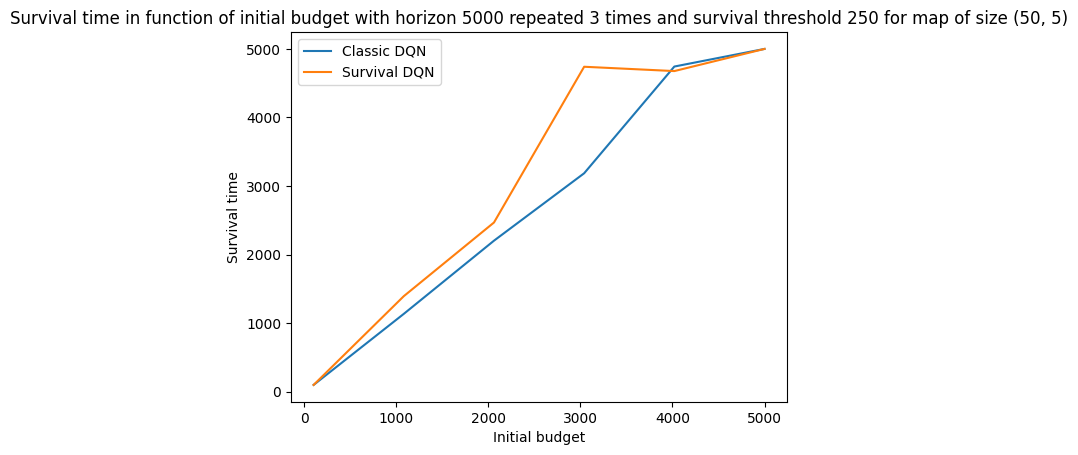

In [5]:
plt.plot(initial_budgets, dqn_time_mean, label="Classic DQN")
plt.plot(initial_budgets, survival_dqn_time_mean, label="Survival DQN")
plt.xlabel("Initial budget")
plt.ylabel("Survival time")
plt.legend()
plt.title(f"Survival time in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Alive rate

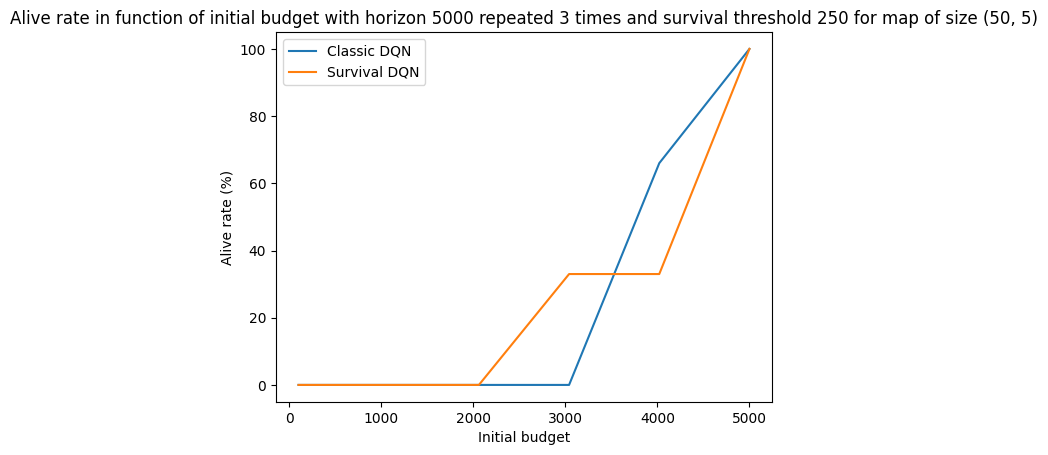

In [6]:
plt.plot(initial_budgets, dqn_alive_rate, label="Classic DQN")
plt.plot(initial_budgets, survival_dqn_alive_rate, label="Survival DQN")
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Exploration rate

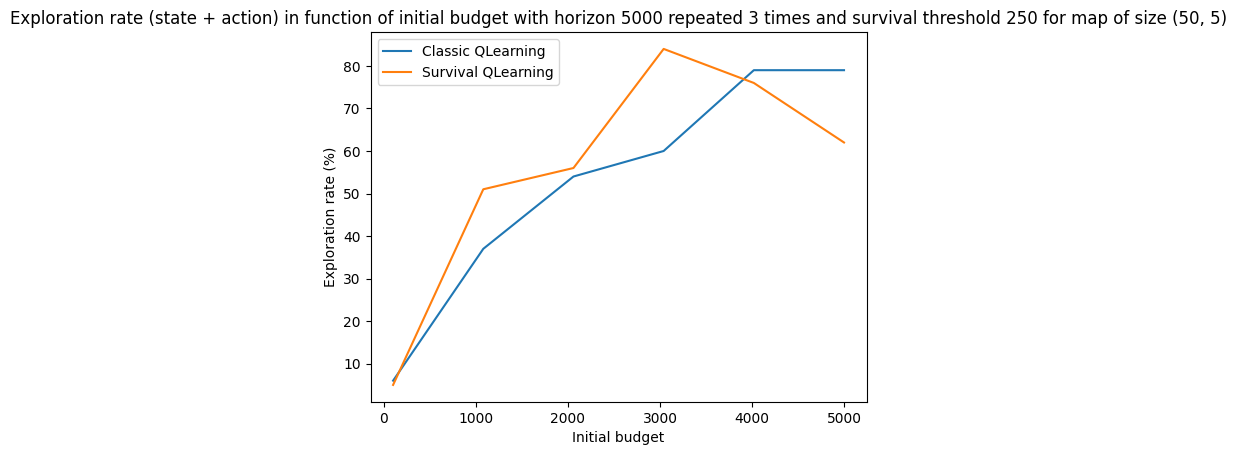

In [7]:
plt.plot(initial_budgets, dqn_exploration_rate, label="Classic QLearning")
plt.plot(initial_budgets, survival_dqn_exploration_rate, label="Survival QLearning")
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.title(f"Exploration rate (state + action) in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Budget evolution

In [8]:
print("Available budgets :")
print(initial_budgets)

Available budgets :
[ 100 1080 2060 3040 4020 5000]


In [9]:
plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = []

#### Classic DQN

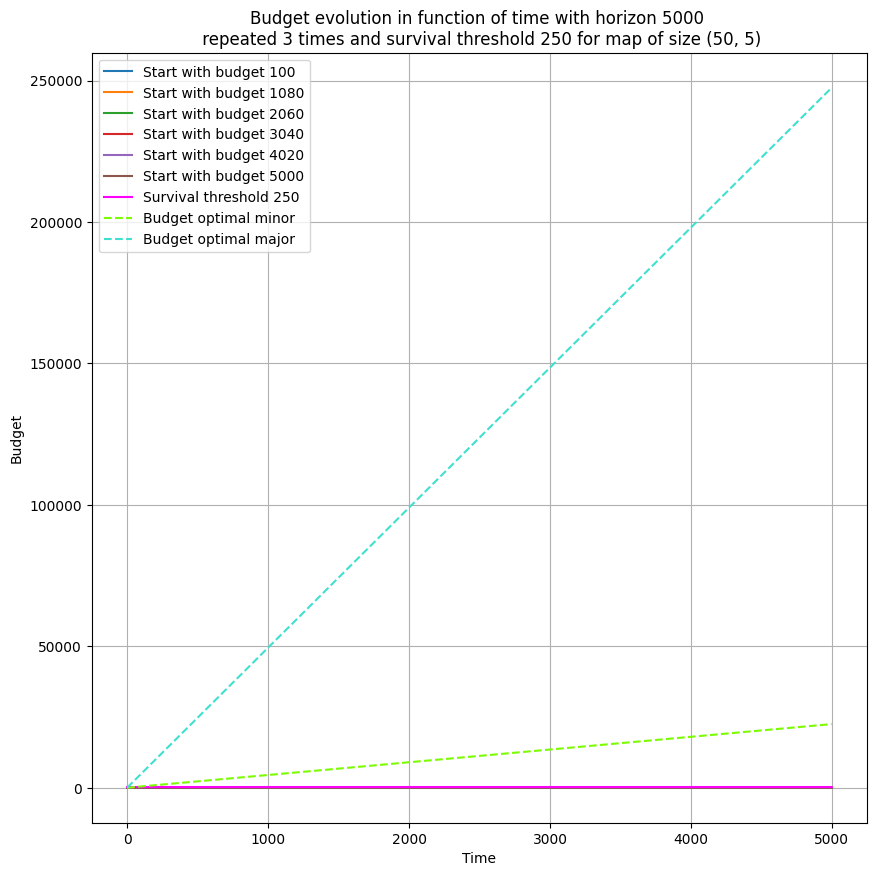

In [10]:
t = np.arange(horizon)

for i, evo in enumerate(dqn_budget_evolutions_mean):
    if len(show_only) > 0 and initial_budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {initial_budgets[i]}")

    if with_bounds:
        plt.fill_between(t, dqn_budget_evolutions_min[i], dqn_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

#### Survival DQN

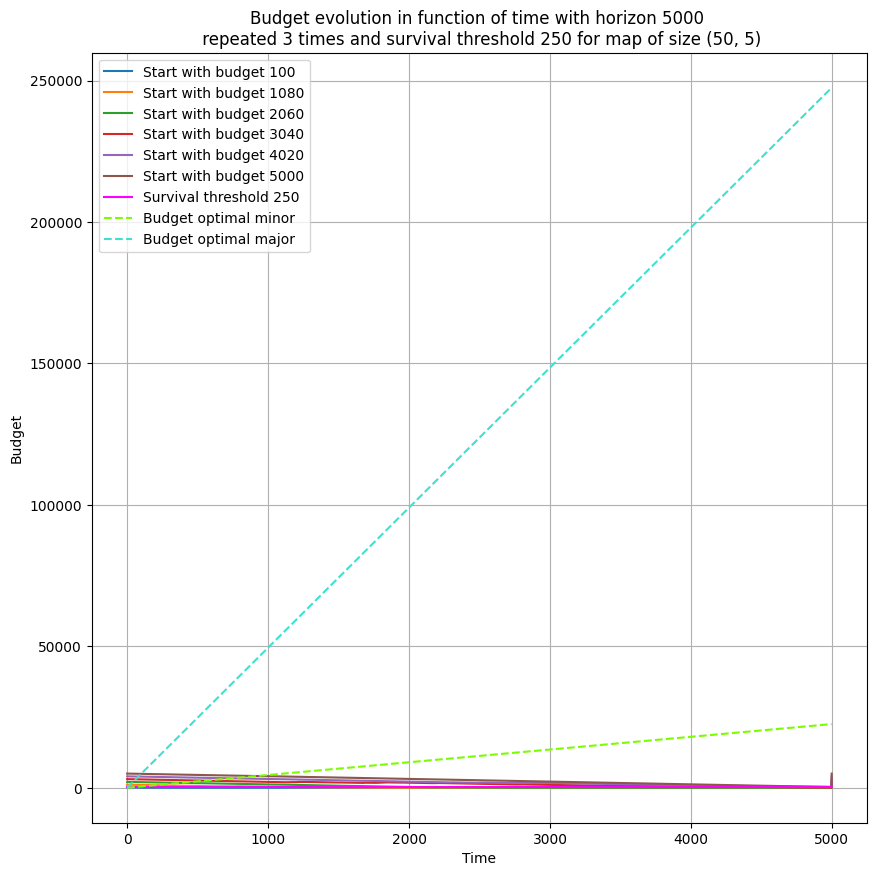

In [11]:
import matplotlib.colors as mcolors

t = np.arange(horizon)

for i, evo in enumerate(survival_dqn_budget_evolutions_mean):
    if len(show_only) > 0 and initial_budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {initial_budgets[i]}")

    if with_bounds:
        plt.fill_between(t, survival_dqn_budget_evolutions_min[i], survival_dqn_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()